In [9]:
import json
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
# Pipeline with Scaledown
stages_id = ["scaledown", "crop", "mirrorx", "mirrory", "bw", "rotate", "watermark"]
stages_suffix = ["_resized", "_cropped", "_mirrorx", "_mirrory", "_bw", "_rot", "_watermarked"]

# Pipeline without Scaledown
stages_id = ["crop", "mirrorx", "mirrory", "bw", "rotate", "watermark"]
stages_suffix = ["_cropped", "_mirrorx", "_mirrory", "_bw", "_rot", "_watermarked"]

# Version 3 with scaledown in between
version="step-v2"
stages_id = ["crop", "scaledown", "mirror", "mirror_bw", "mirror_2rotate", "mirror_3rotate"]
stages_suffix = ["_cropped", "_resized", "_mirror", "_mirror_bw", "_mirror_rot_rot", "_mirror_rot_rot_rot_watermarked"]
moviepy_op_count = [1, 1, 1, 2, 3, 5]


# Version step v3

# stages_helper = ["crop", "scaledown(input for next)", "mirror", "mirror_bw", "mirror_bw_rotate", "mirror_bw_rotate_watermark"]
version="step-v3"
stages_id = ["crop", "scaledown", "mirror", "mirror_bw", "mirror_bw_rotate", "mirror_bw_rotate_watermark"]
stages_suffix = ["_cropped", "_resized", "", "", "", ""]
powerValues = [2048,4096,8192]

# less-memory version
version="step-v3-512mb-memory"
stages_id = ["crop", "scaledown", "mirror", "mirror_bw", "mirror_bw_rotate", "mirror_bw_rotate_watermark"]
stages_suffix = ["_cropped", "_resized", "", "", "", ""]
powerValues = [512]

# multiple-memory version crop->scaledown->mirror_bw->rotate->watermark
version="step-v3"
stages_id = ["crop", "scaledown", "mirror", "mirror_bw", "rotate", "watermark"]
stages_suffix = ["_cropped", "_resized", "_mirror", "_bw", "_rot", "_watermarked"]
powerValues = [1024, 2048, 4096, 8192]

# multiple-memory version: crop->scaledown->(mirror,bw,rotate,watermark)
# version="step-v3"
# stages_id = ["crop", "scaledown", "mirror_bw_rotate", "mirror_bw_rotate_watermark"]
# stages_suffix = ["_cropped", "_resized", "", ""]
# powerValues = [1024, 2048, 4096, 8192]

version="step-noS3"
stages_id = ["app"]
stages_suffix = [""]
powerValues = [1024, 2048, 4096]

# version="step-v3"
# stages_id = ["crop", "scaledown", "mirror", "mirror_bw", "rotate", "watermark"]
# stages_suffix = ["_cropped", "_resized", "_mirror", "_bw", "_rot", "_watermarked"]
# powerValues = [512]


In [24]:
def createConfig(lambda_version, analysis_version, filename, stages_id, stages_suffix, powerValues):
    try:
        os.mkdir('./../scripts/conf/{}'.format(analysis_version))
    except FileExistsError:
        pass

    for stage, suffix in zip(stages_id, stages_suffix):
        input = {}

        input["lambdaARN"] = "arn:aws:lambda:us-west-2:075165449331:function:pipeline-{}-{}".format(stage, lambda_version)
        input["powerValues"] = powerValues
        input["num"] = 30
        input["parallelInvocation"] = "true"
        input["strategy"] = "cost"

        input["payload"] = {}
        input["payload"]["filename"] = filename

        filename = filename + suffix


        with open('./../conf/{}/{}.json'.format(analysis_version, stage), 'w') as f:
            json.dump(input, f)

        np.savetxt('./../conf/{}/stages.csv'.format(analysis_version), np.array(stages_id), fmt="%s")

In [32]:
batch_len = 150
batch_count = int(10*60/batch_len)
print(batch_count)
lambda_version = "step-v3"
filename = "ElephantsDream{}_1_{}_batch".format(batch_len, batch_count)

# # Mono : (crop,scaledown,mirror,bw,rotate,watermark)
step_version="step-agg-csmbrw-{}Sec-batch".format(batch_len)
stages_id = ["app"]
stages_suffix = [""]
powerValues = [1024, 2048, 4096, 8192]
createConfig(lambda_version, step_version, filename, stages_id, stages_suffix, powerValues)


# # Manual : crop->scaledown->mirror->bw->rotate->watermark
step_version="step-agg-c-s-m-b-r-w-{}Sec-batch".format(batch_len)
stages_id = ["crop", "scaledown", "mirror", "bw", "rotate", "watermark"]
stages_suffix = ["_cropped", "_resized", "_mirror", "_bw", "_rot", "_watermarked"]
powerValues = [1024, 2048, 4096, 8192]
createConfig(lambda_version, step_version, filename, stages_id, stages_suffix, powerValues)


# # AGG1 : crop->scaledown->(mirror,bw,rotate,watermark)
step_version="step-agg-c-s-mbrw-{}Sec-batch".format(batch_len)
stages_id = ["crop", "scaledown", "mirror_bw_rotate_watermark"]
stages_suffix = ["_cropped", "_resized", "_mirror_bw_rot_watermarked"]
powerValues = [1024, 2048, 4096, 8192]
createConfig(lambda_version, step_version, filename, stages_id, stages_suffix, powerValues)

# # AGG2 : crop->scaledown->(mirror,bw)->(rotate,watermark)
step_version="step-agg-c-s-mb-rw-{}Sec-batch".format(batch_len)
stages_id = ["crop", "scaledown", "mirror_bw", "rotate_watermark"]
stages_suffix = ["_cropped", "_resized", "_mirror_bw", "_rot_watermarked"]
powerValues = [1024, 2048, 4096, 8192]
createConfig(lambda_version, step_version, filename, stages_id, stages_suffix, powerValues)

# # AGG3 : crop->(scaledown,mirror,bw,rotate,watermark)
step_version="step-agg-c-smbrw-{}Sec-batch".format(batch_len)
stages_id = ["crop", "scaledown_mirror_bw_rotate_watermark"]
stages_suffix = ["_cropped", "_resized_mirror_bw_rot_watermarked"]
powerValues = [1024, 2048, 4096, 8192]
createConfig(lambda_version, step_version, filename, stages_id, stages_suffix, powerValues)

4


In [6]:
global_stats = {}

In [162]:
colors = {'crop':'b', 'scaledown': 'g', 'mirror': 'r', 'bw': 'c','rotate': 'm','watermark':'y', 'mirror_bw_rotate_watermark': 'black' }

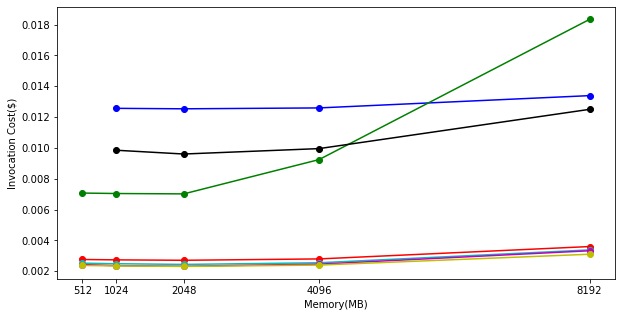

In [166]:
total_lambda_cost = 0
stages_id = ["crop", "scaledown", "mirror", "bw", "rotate", "watermark"]
powerValues = [512,1024,2048,4096,8192]
x_pos = np.arange(len(powerValues))
stats = {1024:0, 2048:0, 4096:0, 8192:0}
plt.figure(figsize=(10,5))
for stage in stages_id: 
    f = open('./../output/step-split-num30-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    stage_stats = []
    if stage == 'crop': stage_stats.append(None)
    for stat in data['stats']:
        stage_stats.append(stat['averagePrice'])
    plt.plot(powerValues, stage_stats, color= colors[stage], label = stage, marker='o')
    f.close()
f = open('./../output/step-agg-num30-v5/{}.json'.format('mirror_bw_rotate_watermark'), 'r')
data = json.load(f)
stage_stats = []
stage_stats.append(None)
for stat in data['stats']:
    stage_stats.append(stat['averagePrice'])
plt.plot(powerValues, stage_stats, color= colors['mirror_bw_rotate_watermark'], label = 'mirror_bw_rotate_watermark', marker='o')
f.close()
#plt.legend()
plt.xlabel('Memory(MB)')
plt.ylabel('Invocation Cost($)')

# Create names on the x axis
plt.xticks(powerValues)
plt.show()

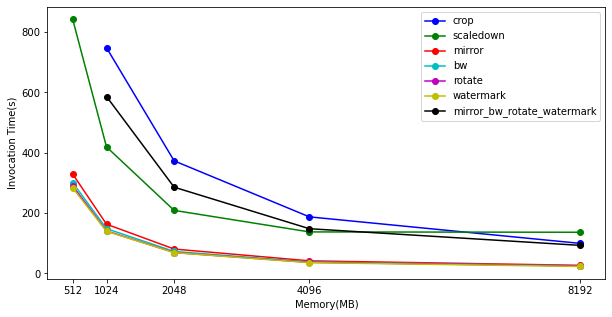

In [167]:
total_lambda_cost = 0
stages_id = ["crop", "scaledown", "mirror", "bw", "rotate", "watermark"]
powerValues = [512,1024,2048,4096,8192]
x_pos = np.arange(len(powerValues))
stats = {1024:0, 2048:0, 4096:0, 8192:0}
plt.figure(figsize=(10,5))
for stage in stages_id: 
    f = open('./../output/step-split-num30-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    stage_stats = []
    if stage == 'crop': stage_stats.append(None)
    for stat in data['stats']:
        stage_stats.append(stat['averageDuration']/1000)
    plt.plot(powerValues, stage_stats, color= colors[stage], label = stage, marker='o')
    f.close()
f = open('./../output/step-agg-num30-v5/{}.json'.format('mirror_bw_rotate_watermark'), 'r')
data = json.load(f)
stage_stats = []
stage_stats.append(None)
for stat in data['stats']:
    stage_stats.append(stat['averageDuration']/1000)
plt.plot(powerValues, stage_stats, color= colors['mirror_bw_rotate_watermark'], label = 'mirror_bw_rotate_watermark', marker='o')
f.close()
plt.legend()
plt.xlabel('Memory(MB)')
plt.ylabel('Invocation Time(s)')
 
# Create names on the x axis
plt.xticks(powerValues)
plt.show()

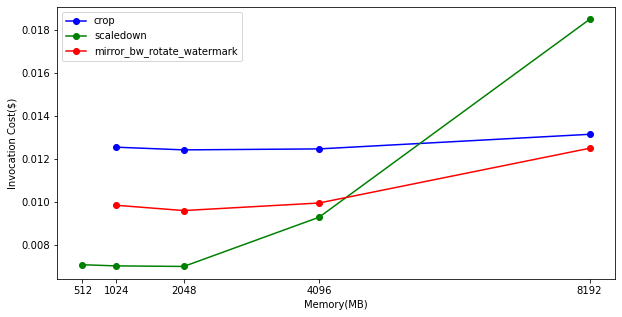

In [134]:
total_lambda_cost = 0
colors = {'crop':'b', 'scaledown': 'g', 'mirror_bw_rotate_watermark': 'r'}
stages_id = ["crop", "scaledown", "mirror_bw_rotate_watermark"]
powerValues = [512,1024,2048,4096,8192]
x_pos = np.arange(len(powerValues))
stats = {1024:0, 2048:0, 4096:0, 8192:0}
plt.figure(figsize=(10,5))
for stage in stages_id: 
    f = open('./../output/step-agg-num30-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    stage_stats = []
    if stage == 'crop' or stage == 'mirror_bw_rotate_watermark': stage_stats.append(None)
    for stat in data['stats']:
        stage_stats.append(stat['averagePrice'])
    plt.plot(powerValues, stage_stats, color= colors[stage], label = stage, marker='o')
    f.close()
plt.legend()
plt.xlabel('Memory(MB)')
plt.ylabel('Invocation Cost($)')
 
# Create names on the x axis
plt.xticks(powerValues)
plt.show()

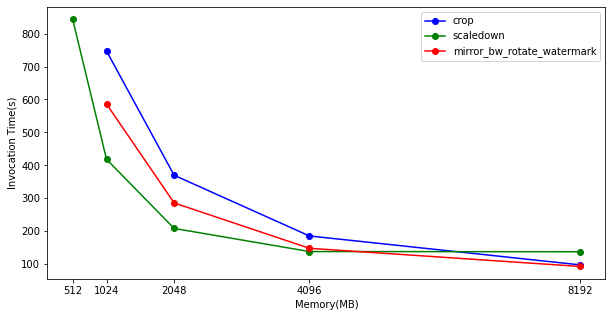

In [135]:
total_lambda_cost = 0
colors = {'crop':'b', 'scaledown': 'g', 'mirror_bw_rotate_watermark': 'r'}
stages_id = ["crop", "scaledown", "mirror_bw_rotate_watermark"]
powerValues = [512,1024,2048,4096,8192]
x_pos = np.arange(len(powerValues))
stats = {1024:0, 2048:0, 4096:0, 8192:0}
plt.figure(figsize=(10,5))
for stage in stages_id: 
    f = open('./../output/step-agg-num30-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    stage_stats = []
    if stage == 'crop' or stage == 'mirror_bw_rotate_watermark': stage_stats.append(None)
    for stat in data['stats']:
        stage_stats.append(stat['averageDuration']/1000)
    plt.plot(powerValues, stage_stats, color= colors[stage], label = stage, marker='o')
    f.close()
plt.legend()
plt.xlabel('Memory(MB)')
plt.ylabel('Invocation Time(s)')
 
# Create names on the x axis
plt.xticks(powerValues)
plt.show()

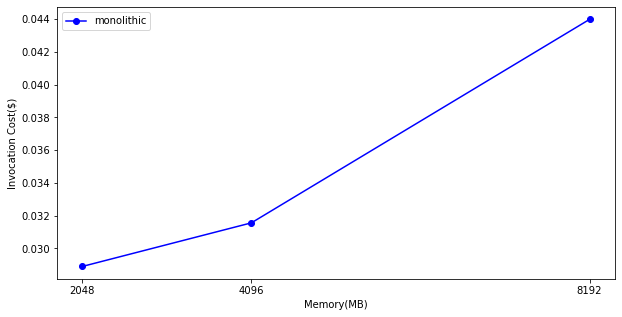

In [137]:
total_lambda_cost = 0
colors = {'monolithic':'b'}
stages_id = ["monolithic"]
powerValues = [2048,4096,8192]
x_pos = np.arange(len(powerValues))
stats = {1024:0, 2048:0, 4096:0, 8192:0}
plt.figure(figsize=(10,5))
for stage in stages_id: 
    f = open('./../output/step-mono-4mins-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    stage_stats = []
    for stat in data['stats']:
        stage_stats.append(stat['averagePrice'])
    plt.plot(powerValues, stage_stats, color= colors[stage], label = stage, marker='o')
    f.close()
plt.legend()
plt.xlabel('Memory(MB)')
plt.ylabel('Invocation Cost($)')
 
# Create names on the x axis
plt.xticks(powerValues)
plt.show()

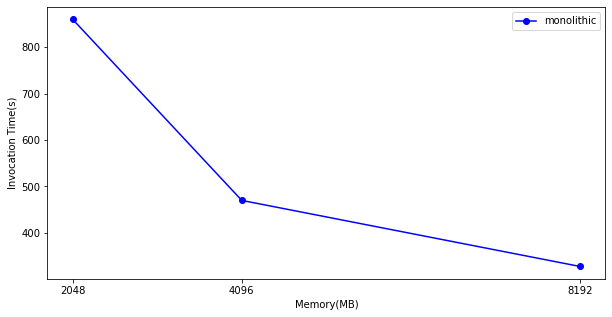

In [138]:
total_lambda_cost = 0
colors = {'monolithic':'b'}
stages_id = ["monolithic"]
powerValues = [2048,4096,8192]
x_pos = np.arange(len(powerValues))
stats = {1024:0, 2048:0, 4096:0, 8192:0}
plt.figure(figsize=(10,5))
for stage in stages_id: 
    f = open('./../output/step-mono-4mins-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    stage_stats = []
    for stat in data['stats']:
        stage_stats.append(stat['averageDuration']/1000)
    plt.plot(powerValues, stage_stats, color= colors[stage], label = stage, marker='o')
    f.close()
plt.legend()
plt.xlabel('Memory(MB)')
plt.ylabel('Invocation Time(s)')
 
# Create names on the x axis
plt.xticks(powerValues)
plt.show()

In [ ]:
total_lambda_cost = 0
stages_id = ["crop", "scaledown", "mirror", "mirror_bw", "rotate", "watermark"]
powerValues = [1024,2048,4096,8192]
stats = {1024:0, 2048:0, 4096:0, 8192:0}
for stage in stages_id: 
    f = open('./../output/step-v4-multi-memory_2/{}.json'.format(stage), 'r')
    data = json.load(f)
    for stat in data['stats']:
        stats[stat['value']] += stat['averagePrice']
    f.close()

In [41]:
total_lambda_cost = 0
stages_id = ["crop", "scaledown", "mirror", "mirror_bw", "rotate", "watermark"]
powerValues = [1024,2048,4096,8192]
stats = {512:0}
for stage in stages_id: 
    f = open('./../output/step-v4-512mb-mem/{}.json'.format(stage), 'r')
    data = json.load(f)
    for stat in data['stats']:
        stats[stat['value']] += stat['averagePrice']
    f.close()

In [42]:
stats

{512: 0.014506195200000002}

In [12]:
total_lambda_cost = 0
stages_id = ["crop", "scaledown", "mirror_bw_rotate_watermark"]
powerValues = [1024,2048,4096,8192]
stats = {1024:0, 2048:0, 4096:0, 8192:0}
for stage in stages_id:
    f = open('./../output/step-v4-multi-memory_1_aggregatedSteps/{}.json'.format(stage), 'r')
    data = json.load(f)
    for stat in data['stats']:
        stats[stat['value']] += stat['averagePrice']
    f.close()

In [13]:
global_stats['aggregation'] = min(stats.values())

In [17]:
f = open('./../output/step-v4-multi-memory_v4/{}.json'.format('app'), 'r')
data = json.load(f)
global_stats['monolithic'] = data['analysis']['cost']

In [18]:
global_stats

{'manual-split': 0.013942555200000002,
 'aggregation': 0.012779793600000002,
 'monolithic': 0.0128393328}

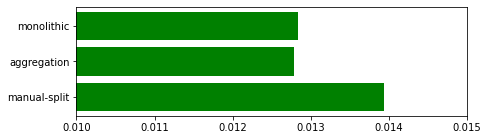

In [62]:
plt.figure(figsize=(7,2))
plt.barh(list(global_stats.keys()), list(global_stats.values()), color='g')
plt.xlim([0.010, 0.015])
plt.show()

In [84]:
averageDuration= 285838.7094444444
totalCost = 0.28806761760000005
avprice = totalCost / averageDuration
print(avprice)

1.0077977827421897e-06


In [145]:
global_stats = {}

In [146]:
total_lambda_cost = 0
stages_id = ["crop", "scaledown", "mirror", "bw", "rotate", "watermark"]
powerValues = [512, 1024,2048,4096,8192]
stats = {512:0, 1024:0, 2048:0, 4096:0, 8192:0}
for stage in stages_id: 
    f = open('./../output/step-split-num30-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    for stat in data['stats']:
        stats[stat['value']] += stat['averagePrice']
    f.close()

In [147]:
stats

{512: 0.0171802512,
 1024: 0.029557500000000004,
 2048: 0.0293557152,
 4096: 0.032058028800000006,
 8192: 0.045153830400000004}

In [148]:
global_stats['manual-split'] = stats[2048]

In [149]:
total_lambda_cost = 0
stages_id = ["crop", "scaledown", "mirror_bw_rotate_watermark"]
powerValues = [1024,2048,4096,8192]
stats = {512:0, 1024:0, 2048:0, 4096:0, 8192:0}
for stage in stages_id:
    f = open('./../output/step-agg-num30-v5/{}.json'.format(stage), 'r')
    data = json.load(f)
    for stat in data['stats']:
        stats[stat['value']] += stat['averagePrice']
    f.close()

In [150]:
global_stats['aggregation'] = stats[2048]

In [124]:
f = open('./../output/step-mono-8min-v6/{}.json'.format('monolithic'), 'r')
data = json.load(f)
global_stats['monolithic'] = data['analysis']['cost']

In [151]:
global_stats

{'manual-split': 0.0293557152, 'aggregation': 0.029035305600000002}

In [168]:
diff = global_stats['manual-split'] - global_stats['aggregation']

In [173]:
diff*1000000

320.40959999999825

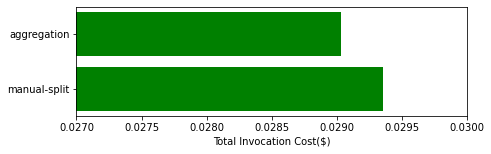

In [154]:
plt.figure(figsize=(7,2))
plt.barh(list(global_stats.keys()), list(global_stats.values()), color='g')
plt.xlim([0.0270, 0.030])
plt.xlabel('Total Invocation Cost($)')
plt.show()